# $\textbf{Wind power forecasting}$
### $\textit{Kirill Zakharov}$
##### $\textit{@kirillzx}$
$2021$

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [2]:
data = pd.read_csv('Turbine_Data.csv', parse_dates=True, index_col='Unnamed: 0')
data.index = pd.DatetimeIndex(data.index, freq='10T')
data = data.drop(['WTG', 'ControlBoxTemperature'], axis=1)
data = data.tz_localize(None)
names = data.columns

In [3]:
# data = data.resample('D').last()
data.head(3)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [5]:
data.shape

(118224, 19)

In [12]:
data1 = data.dropna()
data1 = data1[['ActivePower', 'AmbientTemperatue', 'Blade1PitchAngle', 'WindDirection', 'WindSpeed']]
data1.describe()

,ActivePower,AmbientTemperatue,Blade1PitchAngle,WindDirection,WindSpeed
count,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000
mean,607.131170,28.381903,10.567897,204.963269,5.869203
std,599.599857,4.213329,21.722311,88.862388,2.612695
min,-38.524659,0.000000,-43.156734,0.000000,0.962305
25%,79.662094,25.047413,-0.947070,160.000000,3.900237
50%,397.411226,27.915479,0.274929,181.750000,5.536355
75%,1043.984927,31.298447,9.187188,270.982143,7.430092
max,1779.032433,42.405597,90.143610,357.000000,22.970893


In [13]:
data2 = data.fillna(method='bfill')
data2 = data2[['ActivePower', 'AmbientTemperatue', 'Blade1PitchAngle', 'WindDirection', 'WindSpeed']]
data2.describe()

,ActivePower,AmbientTemperatue,Blade1PitchAngle,WindDirection,WindSpeed
count,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000
mean,618.270991,28.591784,31.581330,199.753483,5.886995
std,613.814274,4.770899,22.078881,92.961925,2.697255
min,-38.524659,0.000000,-43.156734,0.000000,0.000000
25%,76.621418,25.527884,1.685914,136.000000,3.840339
50%,398.731856,28.256318,45.736893,186.250000,5.566179
75%,1084.948613,31.639939,45.736893,283.000000,7.613288
max,1779.032433,42.405597,90.143610,357.000000,22.970893


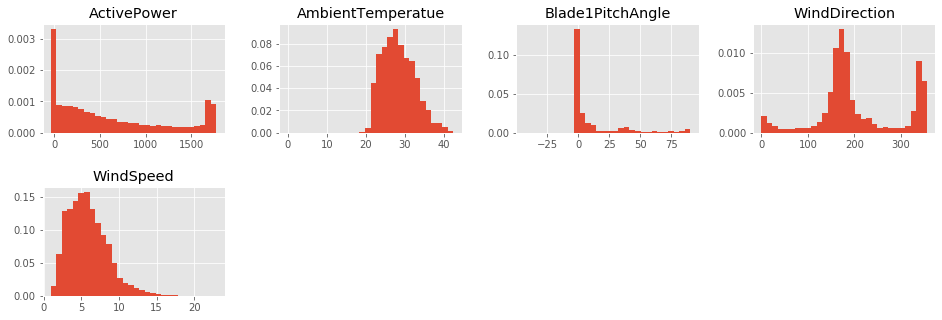

In [21]:
# histograms
data1.hist(figsize=(16, 5), density=True, layout=(2,4), bins=30, sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

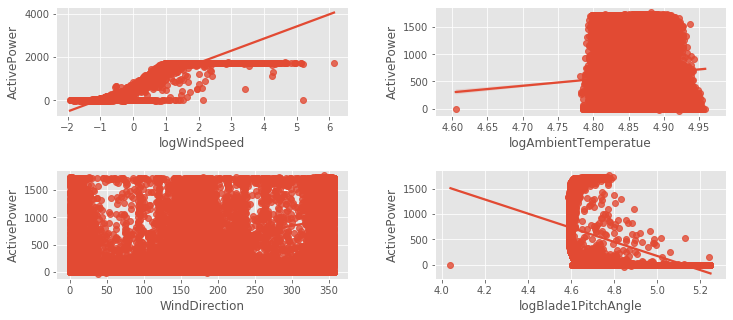

In [188]:
fig, ax = plt.subplots(2, 2, figsize=(12,5))

scaler = StandardScaler()

data1['logWindSpeed'] = pd.DataFrame(scaler.fit_transform(np.array(np.log(data1['WindSpeed']+100)).reshape(-1, 1)), index=data1.index)
data1['logAmbientTemperatue'] = np.log(data1['AmbientTemperatue']+100)
data1['logBlade1PitchAngle'] = np.log(data1['Blade1PitchAngle']+100)

sns.regplot(x='logWindSpeed', y='ActivePower', data=data1, logx=False, ax=ax[0][0])
sns.regplot(x='logAmbientTemperatue', y='ActivePower', data=data1, logx=False, ax=ax[0][1])
sns.regplot(x='WindDirection', y='ActivePower', data=data1, logx=False, ax=ax[1][0])
sns.regplot(x='logBlade1PitchAngle', y='ActivePower', data=data1, logx=False, ax=ax[1][1])

plt.subplots_adjust(hspace=0.5, wspace= 0.3)
plt.show()

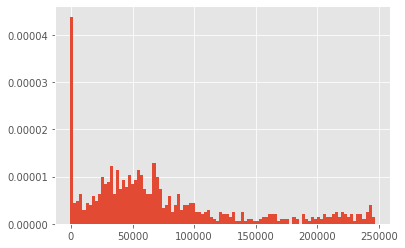

In [23]:
# histograms
data['ActivePower'].resample('D').sum().hist(density=True, bins=100)
plt.subplots_adjust(hspace=1)
plt.show()

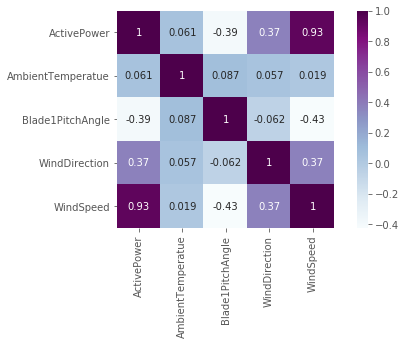

In [27]:
fig = plt.figure(figsize=(8,4))

sns.heatmap(data1.corr(), annot=True, cmap='BuPu', square=True, linewidth=0)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

## Linear model with selected features and droped NaN data

### Without resampling

In [193]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)
Y = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape(-1, 1)), index=Y.index)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [192]:
model = LinearRegression(normalize=True)
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-151.35699405929913

In [58]:
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

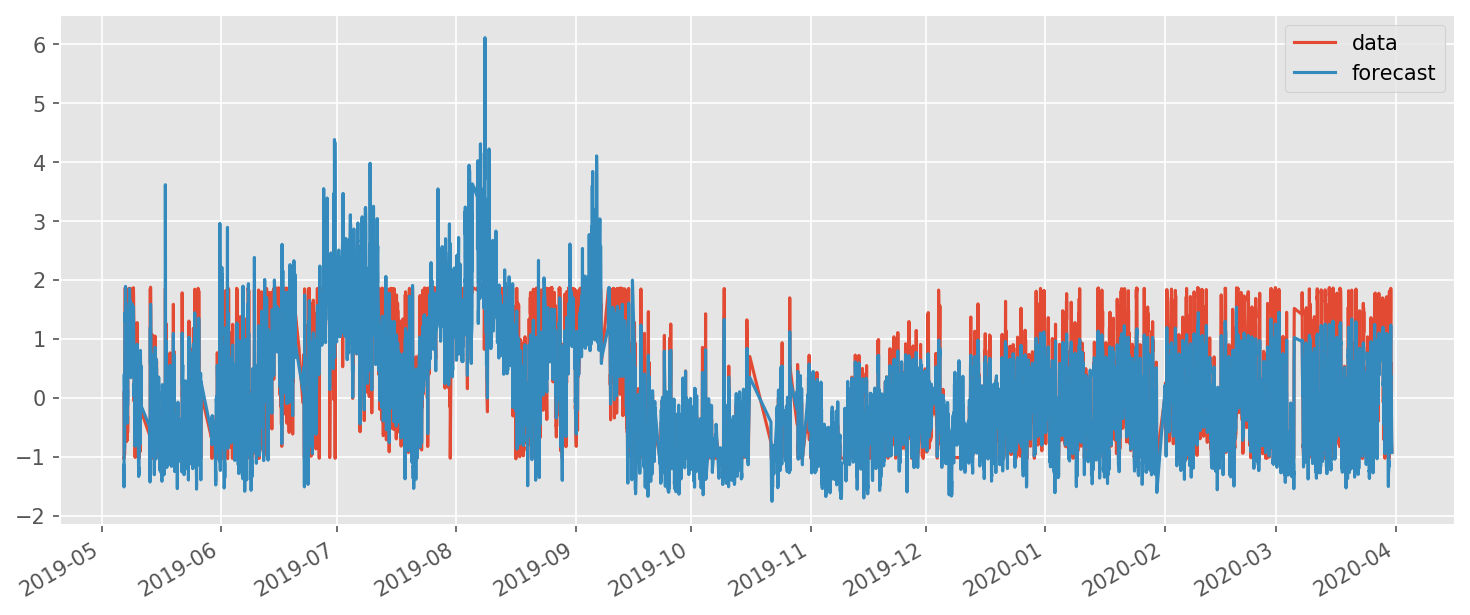

In [73]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.legend()
plt.show()

### Transform to Normal distribution

In [76]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)
Y = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape(-1, 1)), index=Y.index)



validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [80]:
model = LinearRegression(normalize=True)
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv.mean())
model.fit(X_train, Y_train)

-0.25116954019340676


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

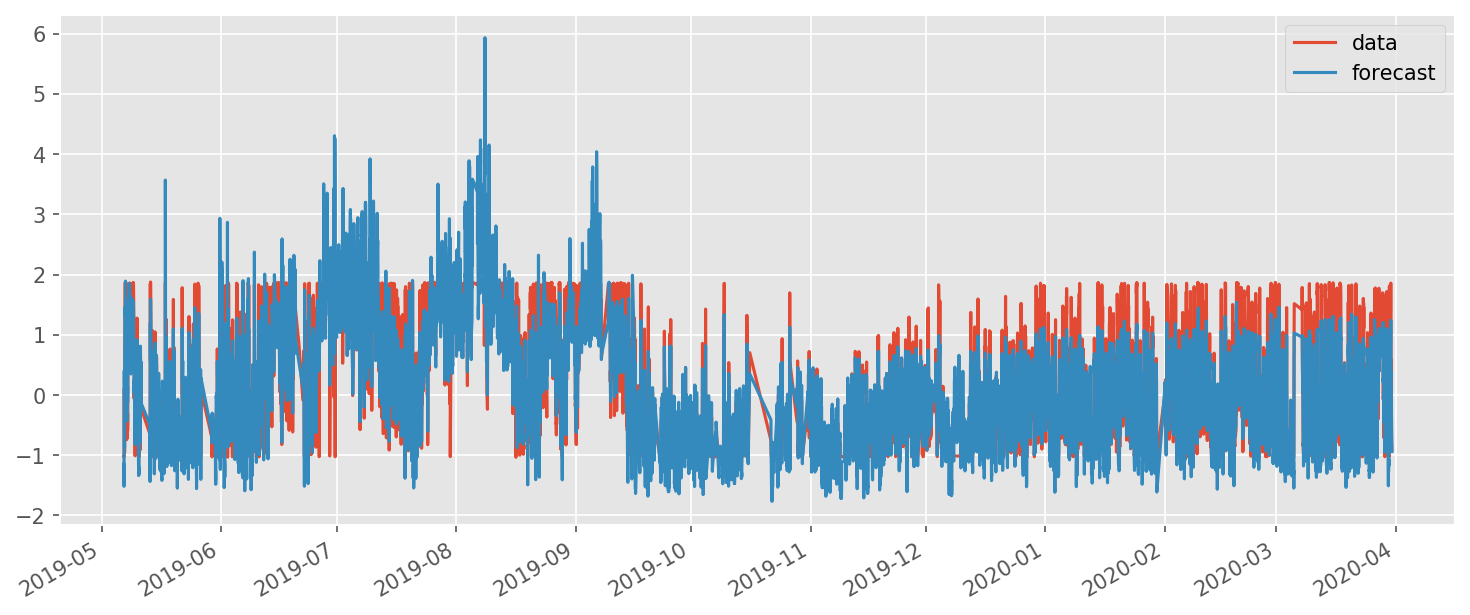

In [81]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

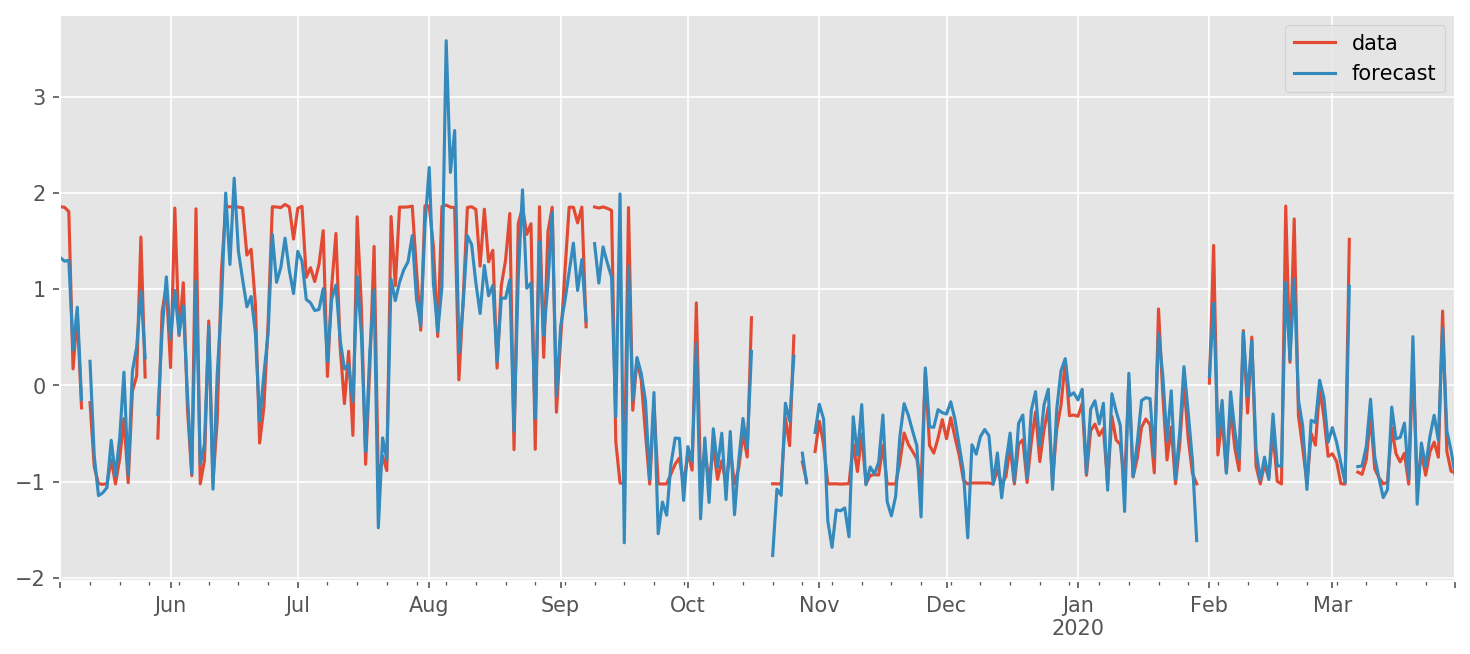

In [82]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

### Generalized linear model

In [206]:
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

linear_regression = sm.GLM(data1['ActivePower'], data1[names_features], \
                           family=sm.families.Gamma())

# linear_regression = sm.GLM(Y, X, \
#                            family=sm.families.Gaussian())
lin_model_results = linear_regression.fit()

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:296: DomainWarning:

The inverse_power link function does not respect the domain of the Gamma family.



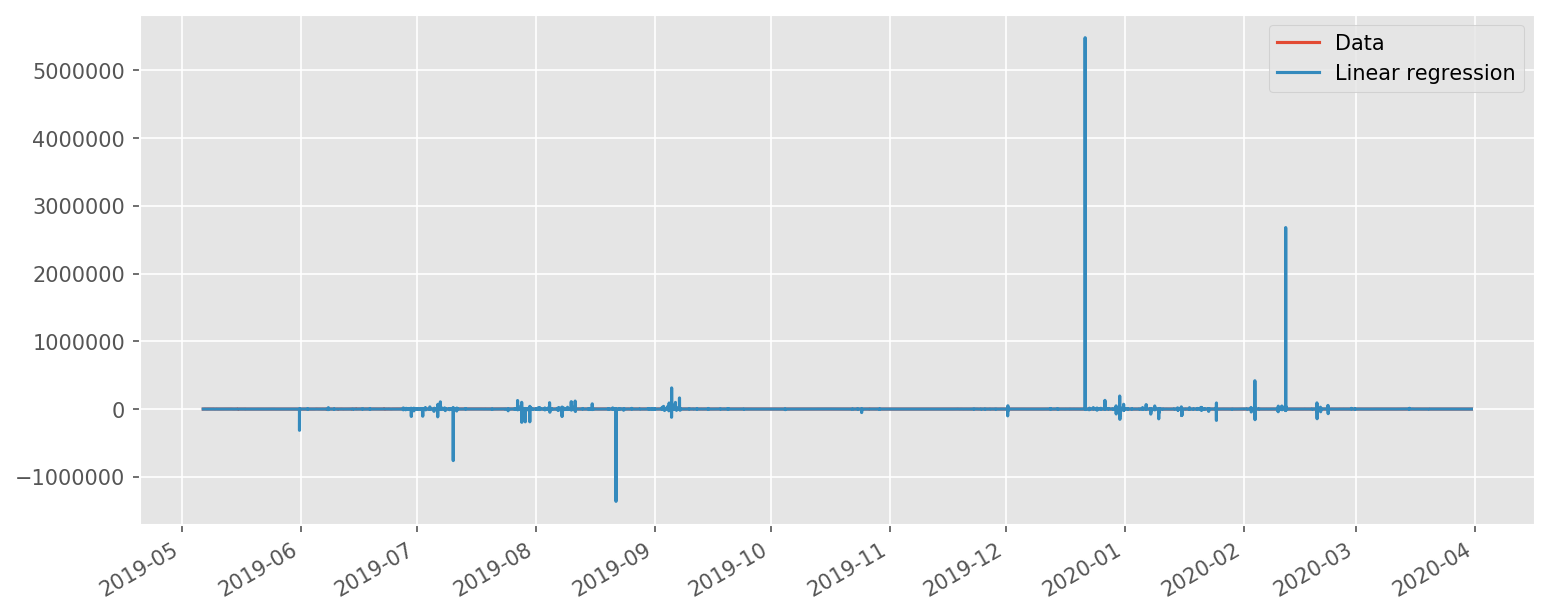

In [207]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
data1['ActivePower'].plot(label='Data')
lin_model_results.fittedvalues.plot(label='Linear regression')
plt.legend()
plt.show()

In [208]:
mean_absolute_error(data1['ActivePower'], lin_model_results.fittedvalues)

1032.946268872216

### Only prophet

In [89]:
data_prophet = data1[['ActivePower']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
    
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.fit(data_prophet)
    
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

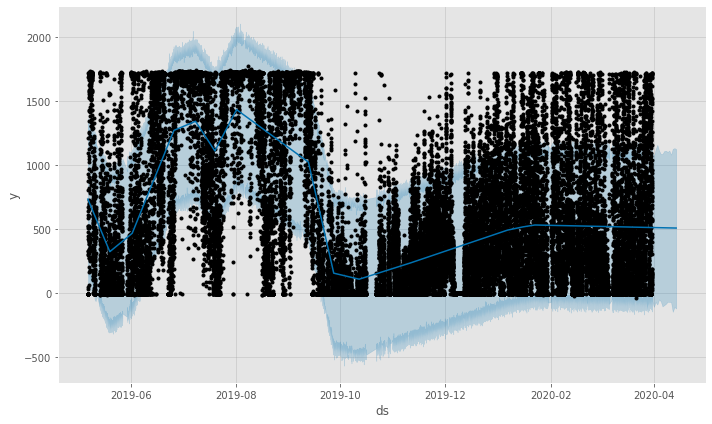

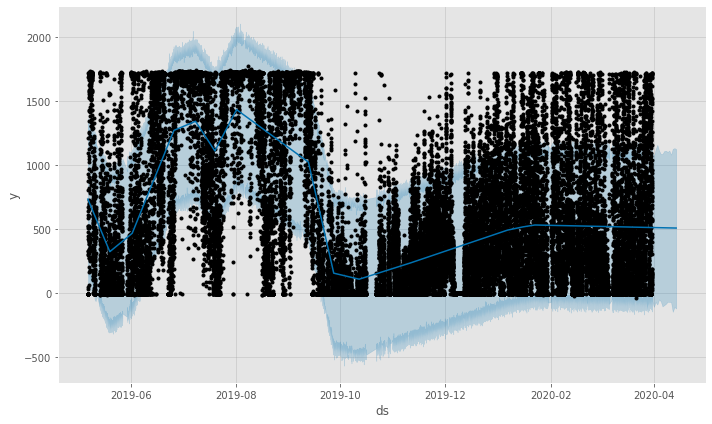

In [90]:
model.plot(forecast)

## Model with selected features and filled data 

In [91]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']

X = data2[names_features]
Y = data2.iloc[:, 0]
X = X.copy()
Y = Y.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)
Y = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape(-1, 1)), index=Y.index)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

model = LinearRegression(normalize=True)

# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-0.2694663401716544

In [94]:
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

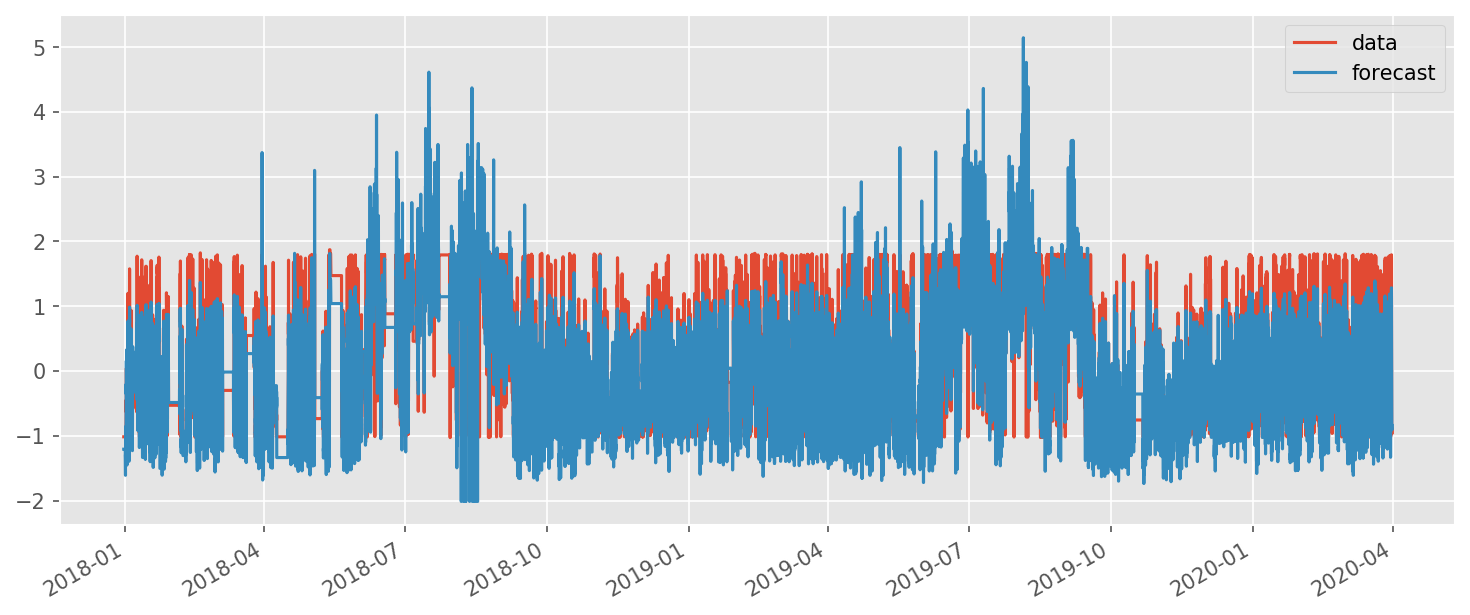

In [95]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.show()

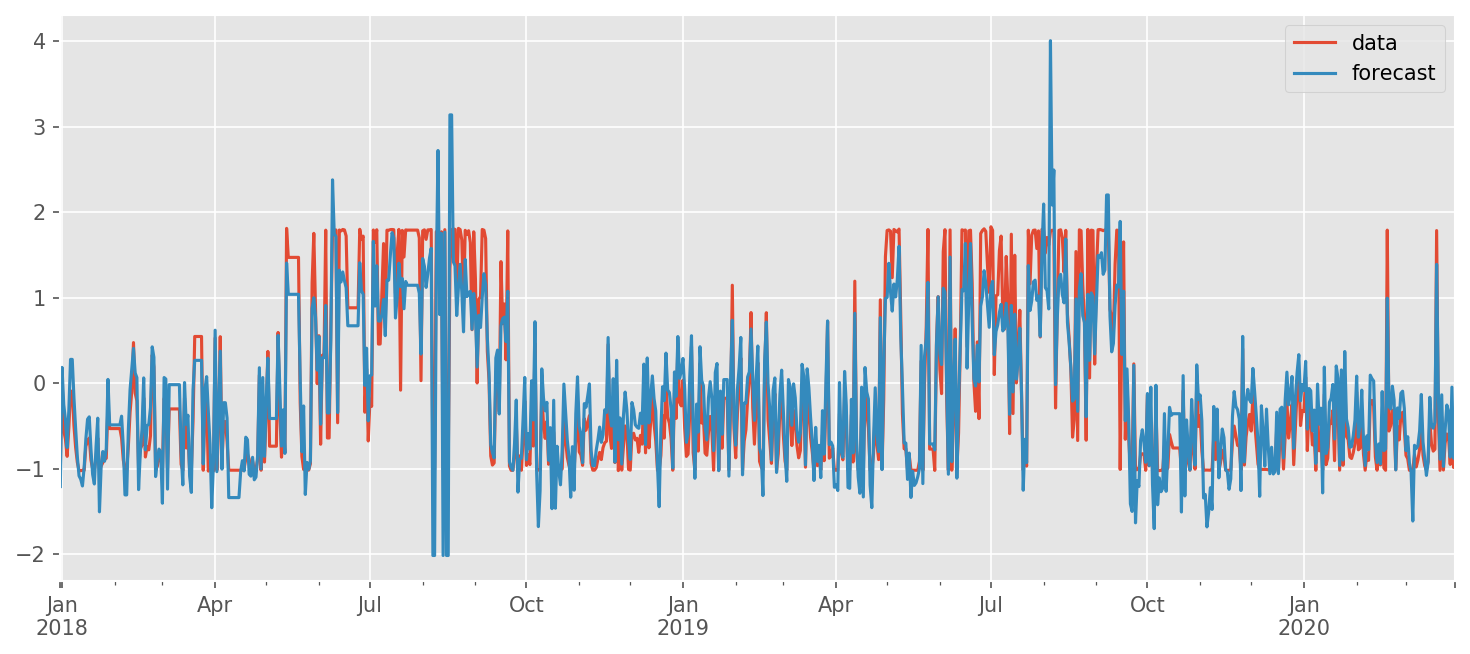

In [96]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

In [97]:
linear_regression = sm.GLM(data2['ActivePower'], data2[names_features], \
                           family=sm.families.Gaussian())
lin_model_results = linear_regression.fit()

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



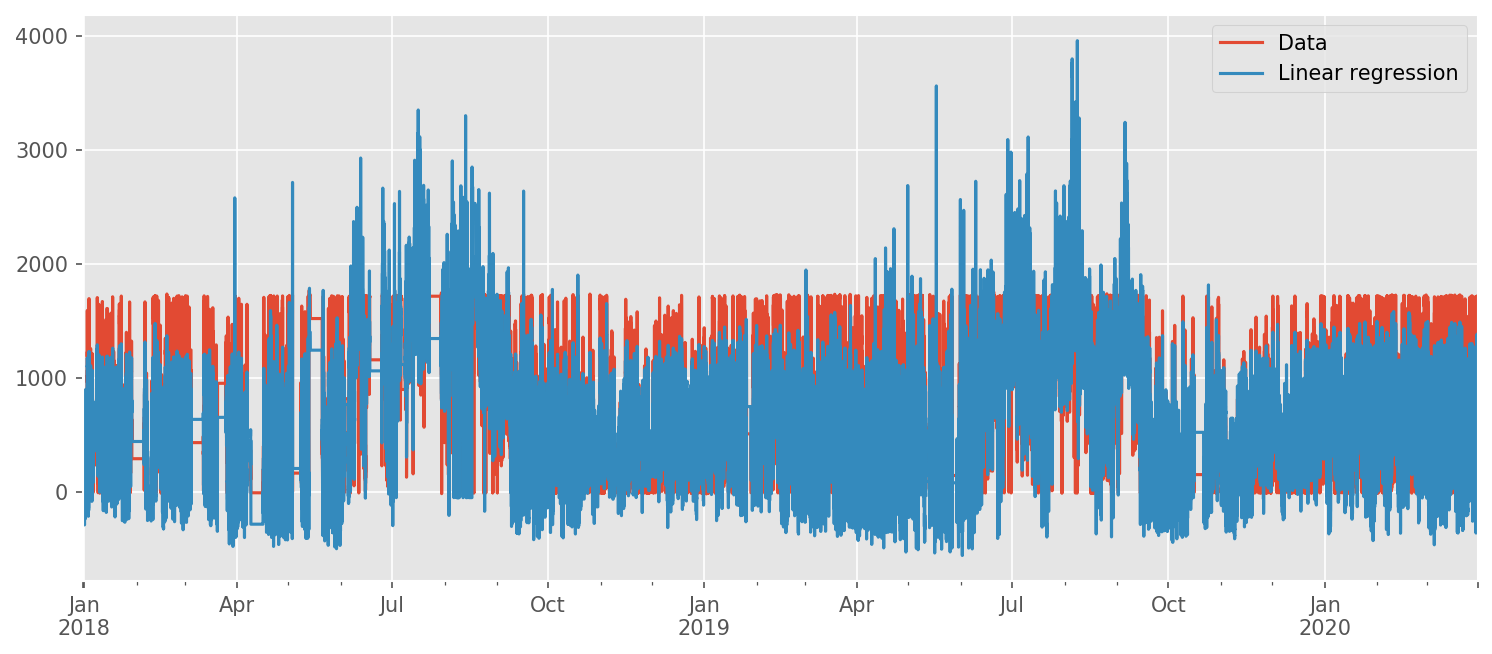

In [98]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
data2['ActivePower'].plot(label='Data')
lin_model_results.fittedvalues.plot(label='Linear regression')
plt.legend()
plt.show()

In [99]:
mean_absolute_error(data2['ActivePower'], lin_model_results.fittedvalues)

188.09621018777707

## Prediction

In [41]:
data3 = data.resample('D').last().dropna()

def features_forecast(name, period):
#     data_prophet = data1[[name]]
    
    data_prophet = data3[[name]]
    data_prophet = data_prophet.reset_index()
    data_prophet.columns = ['ds', 'y']
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    model.fit(data_prophet)
    
    future = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(future)
    return forecast['yhat'].values[-period:]

In [42]:
forecast_values = []
# names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
names_features = ['AmbientTemperatue', 'WindSpeed']
period = 7
for name in names_features:
    forecast_values.append(features_forecast(name, period))

In [43]:
X = data3[names_features]
X = X.copy()
X['blades'] = blade_model.predict(X.iloc[:, 1:])
Y = data3.iloc[:, 0]

X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+1)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

model = LinearRegression(normalize=False)
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv.mean())
model.fit(X_train, Y_train)
np.around(model.coef_)

-97.65871951671892


array([  425., -1387.,   -14.])

In [44]:
x_blade_fc = blade_model.predict(np.array(forecast_values[1:]).T)
forecast_values.append(x_blade_fc.reshape(1, -1)[-1])

In [45]:
start = data3.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=period-1)
forecast_df = pd.DataFrame(model.predict(np.array(forecast_values).T),\
                           index=pd.date_range(start, end), columns=['forecast'])

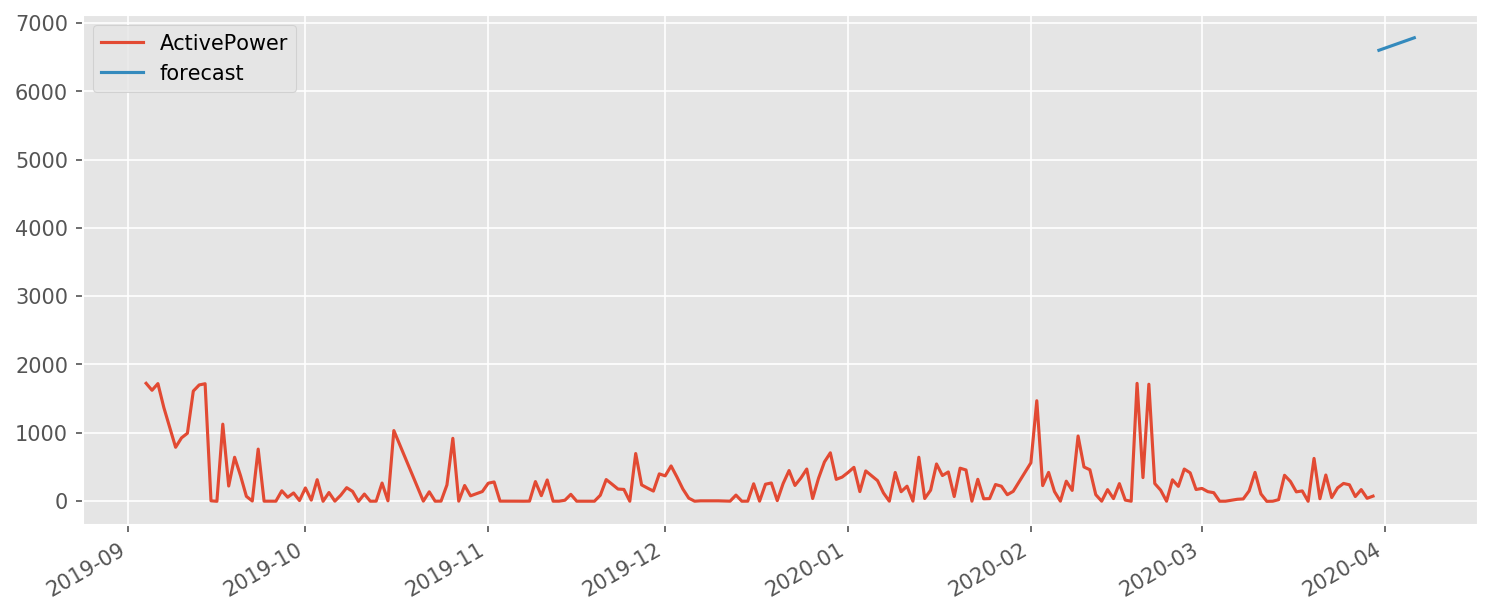

In [46]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

data3['ActivePower'].iloc[-200:].plot()
forecast_df.plot(ax=ax)
plt.legend()
plt.show()

# ARIMAX

Оптимальный параметр преобразования Бокса-Кокса: 0.232821
Критерий Дики-Фуллера: p=0.000000


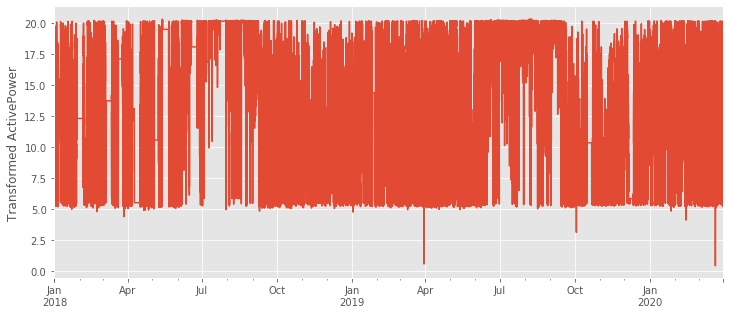

In [100]:
data_sarimax = pd.DataFrame(index = data2.index)
# data_sarimax = pd.DatetimeIndex(data_sarimax.index, freq='10T')

data_sarimax['ActivePower'] = data2['ActivePower'].values
data_sarimax['WindSpeed'] = data2['WindSpeed'].values
data_sarimax['WindDirection'] = data2['WindDirection'].values
data_sarimax['AmbientTemperature'] = data2['AmbientTemperatue'].values

data_sarimax['ActivePower_box'], lmbda = boxcox(data2['ActivePower']+40)
data_sarimax['const'] = 1
data_sarimax['ActivePower_box'].plot(figsize=(12,5))
plt.ylabel('Transformed ActivePower')

print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_sarimax['ActivePower_box'])[1])

Критерий Дики-Фуллера: p=0.000000


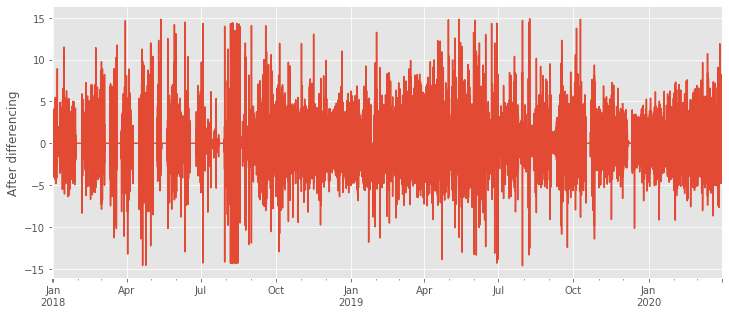

In [101]:
data_sarimax['ActivePower_box_diff'] =  data_sarimax['ActivePower_box'].diff(1)
data_sarimax['ActivePower_box_diff'].plot(figsize=(12,5))
plt.ylabel('After differencing')
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_sarimax['ActivePower_box_diff'].dropna())[1])

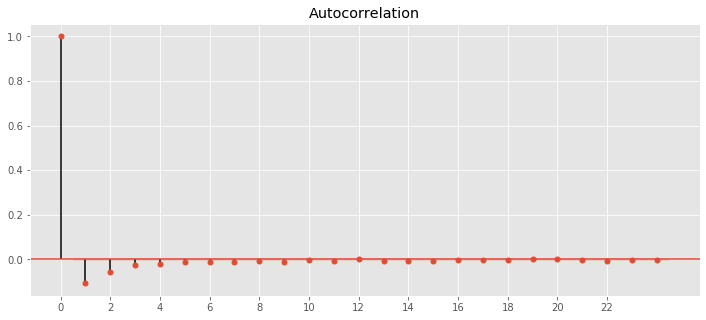

In [102]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data_sarimax['ActivePower_box_diff'].dropna(), lags=24)
plt.xticks(np.arange(0, 24, 2))
plt.show()

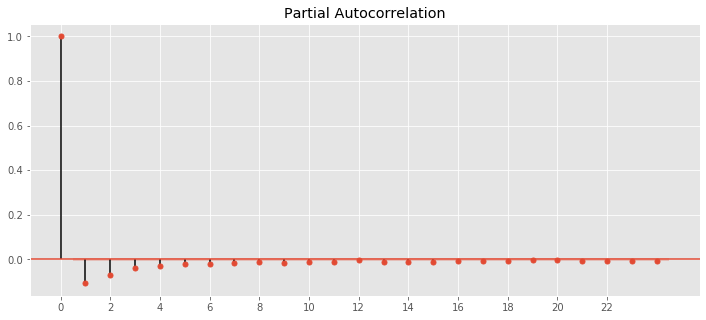

In [103]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(data_sarimax['ActivePower_box_diff'].dropna(), lags=24)
plt.xticks(np.arange(0, 24, 2))
plt.show()

In [104]:
d=1
p = range(1, 5)
q = range(1, 5)

In [98]:
parameters = product(p, q)
parameters_list = list(parameters)

In [99]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(data_sarimax['ActivePower_box'], order=(params[0], d, params[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inf

In [100]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

   parameters            aic
15     (4, 4)  386058.494899
3      (1, 4)  386060.576178
12     (4, 1)  386079.776500
2      (1, 3)  386088.434919
7      (2, 4)  386090.688339


In [105]:
model_sarimax = SARIMAX(data_sarimax['ActivePower_box'], order=(1, 1, 1), \
                        exog=data_sarimax[['WindSpeed', 'WindDirection','AmbientTemperature', 'const']]).fit()

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency 10T will be used.



C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



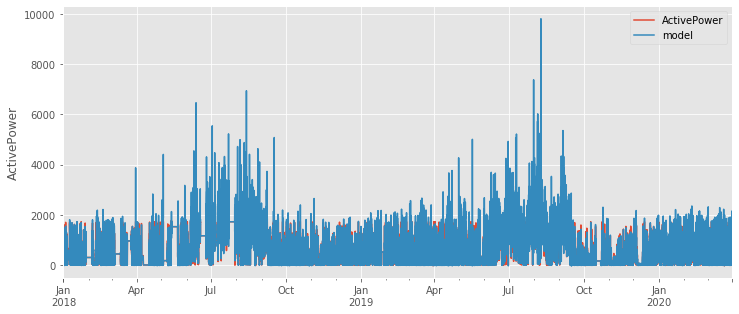

In [167]:
data_sarimax['model'] = inv_boxcox(model_sarimax.fittedvalues, lmbda)-40
data_sarimax['ActivePower'].plot(figsize=(12,5))
data_sarimax.model[13:].plot()
plt.ylabel('ActivePower')
plt.legend()
plt.show()

In [168]:
mean_absolute_error(data_sarimax['model'].dropna().values, \
            data_sarimax['ActivePower'].drop(data_sarimax['model'].index[data_sarimax['model'].apply(np.isnan)][0]).values)

66.45105095084635

In [169]:
start = data_sarimax.index[-1] + pd.DateOffset(minutes=10)
end = start + pd.DateOffset(minutes=1440*2)

In [ ]:
data_sarimax.iloc[-500:,0].plot(figsize=(12,5))
inv_boxcox(model_sarimax.predict(start=start, end=end), lmbda).plot()
plt.ylabel('ActivePower')
plt.show()